<a href="https://colab.research.google.com/github/tyzurc/ds_fraud/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, cross_val_predict, train_test_split, StratifiedShuffleSplit, cross_val_predict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Coderhouse/Data Science/Datasets'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Coderhouse/Data Science/Datasets


# Abstract

Es importante que los bancos puedan reconocer las transacciones de tarjetas de crédito fraudulentas para que a sus clientes no se les cobre por artículos que no compraron. En ese sentido, se escogió un conjunto de datos que contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Dichas transacciones ocurrieron en dos días, en los que resultaron 492 fraudes de 284.807 transacciones, representando un 0.172 % de todas las transacciones.

En este caso particular, el dataset solo contiene variables de entrada numéricas, resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no se puede conocer las características originales ni más información general sobre los datos. Las características V1, V2, … V28 son los principales componentes obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Time' y 'Amount'. La característica 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Amount' es el monto de la transacción, esta característica en específico será utilizada posteriormente para poder evaluar el comportamiento de los montos en transacciones fraudulentas. 'Class' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.

Con el análisis, se busca responder a las siguientes interrogantes: ¿qué características en común comparten los casos fraudulentos? ¿cuáles son las características con más probabilidad de presentar casos de fraude? ¿qué horarios son los más frecuentados para este tipo de transacciones? ¿cómo se comportan los montos de transacciones fraudulentas durante el tiempo?

# Objetivo

¿Se puede detectar patrones entre las características de tarjetas de crédito para identificar posibles fraudes?

# Contexto comercial

Las entidades bancarias, para garantizar su seguridad y la de sus clientes, suelen contar con un equipo de fraude que analiza las diferentes transacciones que se realicen.

En este caso específico, los créditos deben ser controlados y evaluados para determinar su legitimidad y aprobación final.

Sin embargo, a pesar de los distintos mecanismos de seguridad, puede haber transacciones fraudulentas que resulten en el perjuicio de los clientes (o incluso de la misma entidad bancaria).

Es función del equipo de fraude, determinar qué características de las transacciones realizadas con tarjetas de crédito son más vulnerables o no a este tipo de situaciones.

# Problema comercial

Se busca responder a la siguiente pregunta:

¿Existe patrones entre las características de tarjetas de crédito que puedan estár más propensas a presentar transacciones fraudulentas?

# Contexto analítico

El conjunto de datos que contiene 284.807 transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Las transacciones están etiquetadas como fraudulentas o no fraudulentas, por lo que puede servir para analizar las características en común que tengan estos casos, para así analizar y predecir comportamientos a futuro.

# EDA

## Carga y revisión de datos

In [ ]:
# Lectura e info del dataset

filename = 'creditcard.csv'
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Revisión rápida del contenido

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Chequeo de valores faltantes

df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Proporción de fraude detectado

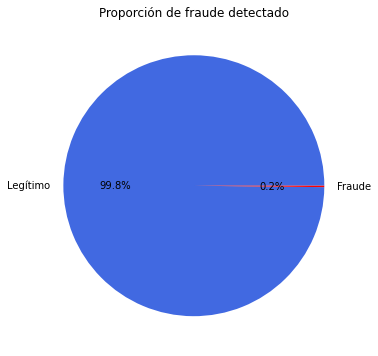

In [ ]:
plt.figure(figsize=(8,6))
labels=['Legítimo' , 'Fraude']
explode = [0,0]
color=['royalblue' , 'red']
data=df['Class'].value_counts().values

plt.pie(data,explode,labels,autopct="%1.1f%%", colors = color)
plt.title('Proporción de fraude detectado')
plt.show()

Se observa que el 99,8% de las transacciones fueron legítimas y el 0,2% de las transacciones fueron fraudulentas. Esto indica que el dataset que se está utilizando, está altamente desbalanceado.

In [ ]:
print('Transacciones legítimas:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% del dataset')
print('Transacciones fraudulentas:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% del dataset')

Transacciones legítimas: 99.83 % del dataset
Transacciones fraudulentas: 0.17 % del dataset


## Distribución de montos

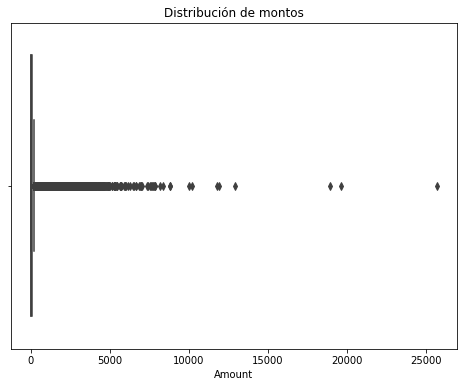

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Amount'], orient='h')
plt.title('Distribución de montos')
plt.show()

Hay muchos valores atípicos en la distribución. La cantidad más alta es mayor que 25000.

<Figure size 576x432 with 0 Axes>

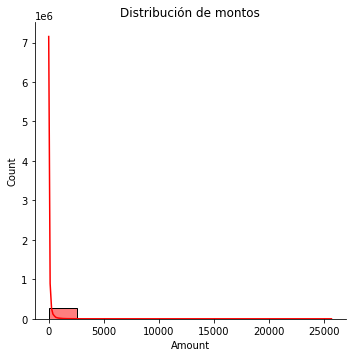

In [ ]:
plt.figure(figsize=(8,6))
sns.displot(x=df['Amount'], kde=True, bins=10, color='red')
plt.title('Distribución de montos')
plt.show()

In [ ]:
max_amount_fraud = df[(df['Class'] == 1)]['Amount'].max()
min_amount_fraud = df[(df['Class'] == 1)]['Amount'].min()
max_amount_nonfraud = df[(df['Class'] == 0)]['Amount'].max()
min_amount_nonfraud = df[(df['Class'] == 0)]['Amount'].min()

print(f'Monto máximo en transacciones fraudulentas = {max_amount_fraud}')
print(f'Monto mínimo en transacciones fraudulentas = {min_amount_fraud}')
print(f'Monto máximo en transacciones no fraudulentas = {max_amount_nonfraud}')
print(f'Monto mínimo en transacciones no fraudulentas = {min_amount_nonfraud}')

Monto máximo en transacciones fraudulentas = 2125.87
Monto mínimo en transacciones fraudulentas = 0.0
Monto máximo en transacciones no fraudulentas = 25691.16
Monto mínimo en transacciones no fraudulentas = 0.0


## Distribución de transacciones por monto

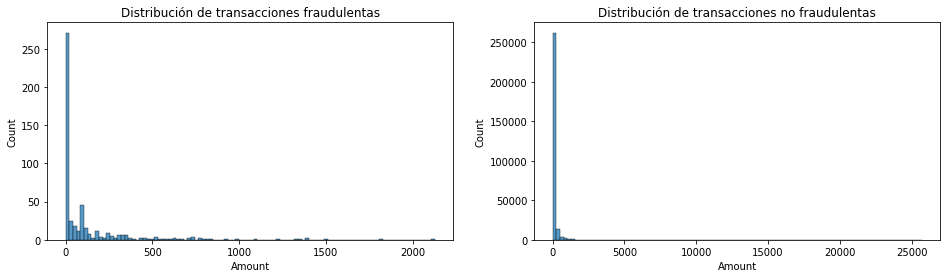

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.histplot(df[df['Class'] == 1]['Amount'], bins=100, ax=axs[0])
axs[0].set_title('Distribución de transacciones fraudulentas')

sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, ax=axs[1])
axs[1].set_title('Distribución de transacciones no fraudulentas')

plt.show()

Este gráfico muestra que la mayor parte del monto de las transacciones fraudulentas es inferior a 500 euros.

## Distribución en el tiempo

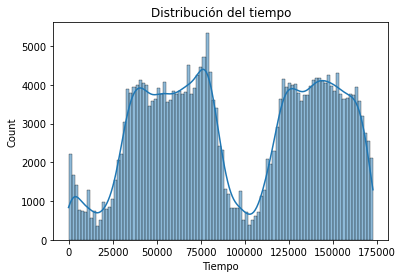

In [ ]:
sns.histplot(data=df, x='Time', kde=True, bins=100)
plt.title('Distribución del tiempo')
plt.xlabel('Tiempo')
plt.show()

Al ver el gráfico, se observa que hay dos picos importantes. Se pueden interpretar como la horas horas pico del día en los que la mayoría de la gente hace las transacciones.

## Relación entre tiempo y monto

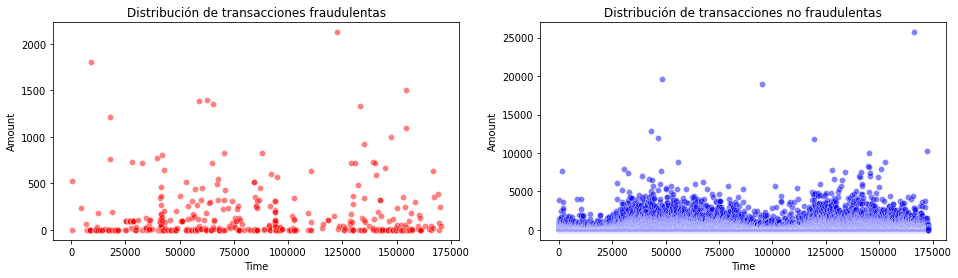

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==1], ax=axs[0],color='#FF0000',alpha = 0.5)
axs[0].set_title('Distribución de transacciones fraudulentas')

sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==0], ax=axs[1],color='#0000FF',alpha = 0.5)
axs[1].set_title('Distribución de transacciones no fraudulentas')

plt.show()

Se observa que existe una amplia variación entre los diferentes puntos en el conjunto de datos de fraude. Sin embargo, el conjunto de datos sin fraude se comporta de manera contraria, exceptuando los puntos con una cantidad superior a 2500.

## Distribución y correlación de los datos


- Debido a que la mayoría de los datos se encuentran escalados, se debería escalar también las columnas "Amount" y "Time".

In [ ]:
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


- Hay 492 casos de fraude, así que se pueden seleccionar 492 casos de transacciones legítimas al azar para crear un subconjunto de datos.

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
65439,-0.194648,-0.388961,1.236445,-0.161662,0.616486,-0.085567,-0.717561,-0.428120,-0.453537,0.099592,...,-0.092611,-0.173456,-0.599937,0.110651,0.016743,-0.008708,0.794336,-0.073363,-0.000179,0
63634,1.089779,-0.398078,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,...,0.816652,0.926157,-0.817706,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,1
78698,0.809753,-0.317661,1.274022,-0.687615,0.022347,-0.788367,-0.785498,-0.636110,-0.390688,-0.132823,...,0.224506,0.282524,0.557454,-0.226717,0.046418,0.617574,-0.120728,-0.023808,0.008825,0
124115,-0.293440,-0.088229,-1.410852,2.268271,-2.297554,1.871331,0.248957,-1.208799,-1.358648,1.102916,...,0.058063,0.155381,-0.614880,-0.196126,-0.464376,0.118473,-0.484537,0.373596,0.187657,1
204079,1.208831,0.592230,1.862102,-0.124052,-1.989752,0.382609,0.473032,-0.674517,0.298621,-0.282416,...,0.150727,-0.204158,-0.511441,0.077874,0.388335,0.007896,-0.120980,-0.019579,0.006155,1


Distibución de clases en el nuevo subconjunto
0    0.5
1    0.5
Name: Class, dtype: float64


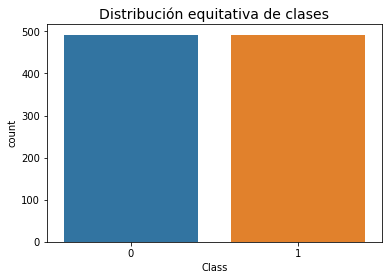

In [ ]:
print('Distibución de clases en el nuevo subconjunto')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Distribución equitativa de clases', fontsize=14)
plt.show()

Ahora que la distribución está balanceada, se puede proceder con el análisis.

# Feature selection

En este caso, la dimensionalidad del dataset ya fue previamente reducida, debido a que se realizó un análisis con PCA previo. Por ende, se trabajará sobre los features directamente obtenidos del dataset original, aplicando algunas transformaciones para limpiar los datos.

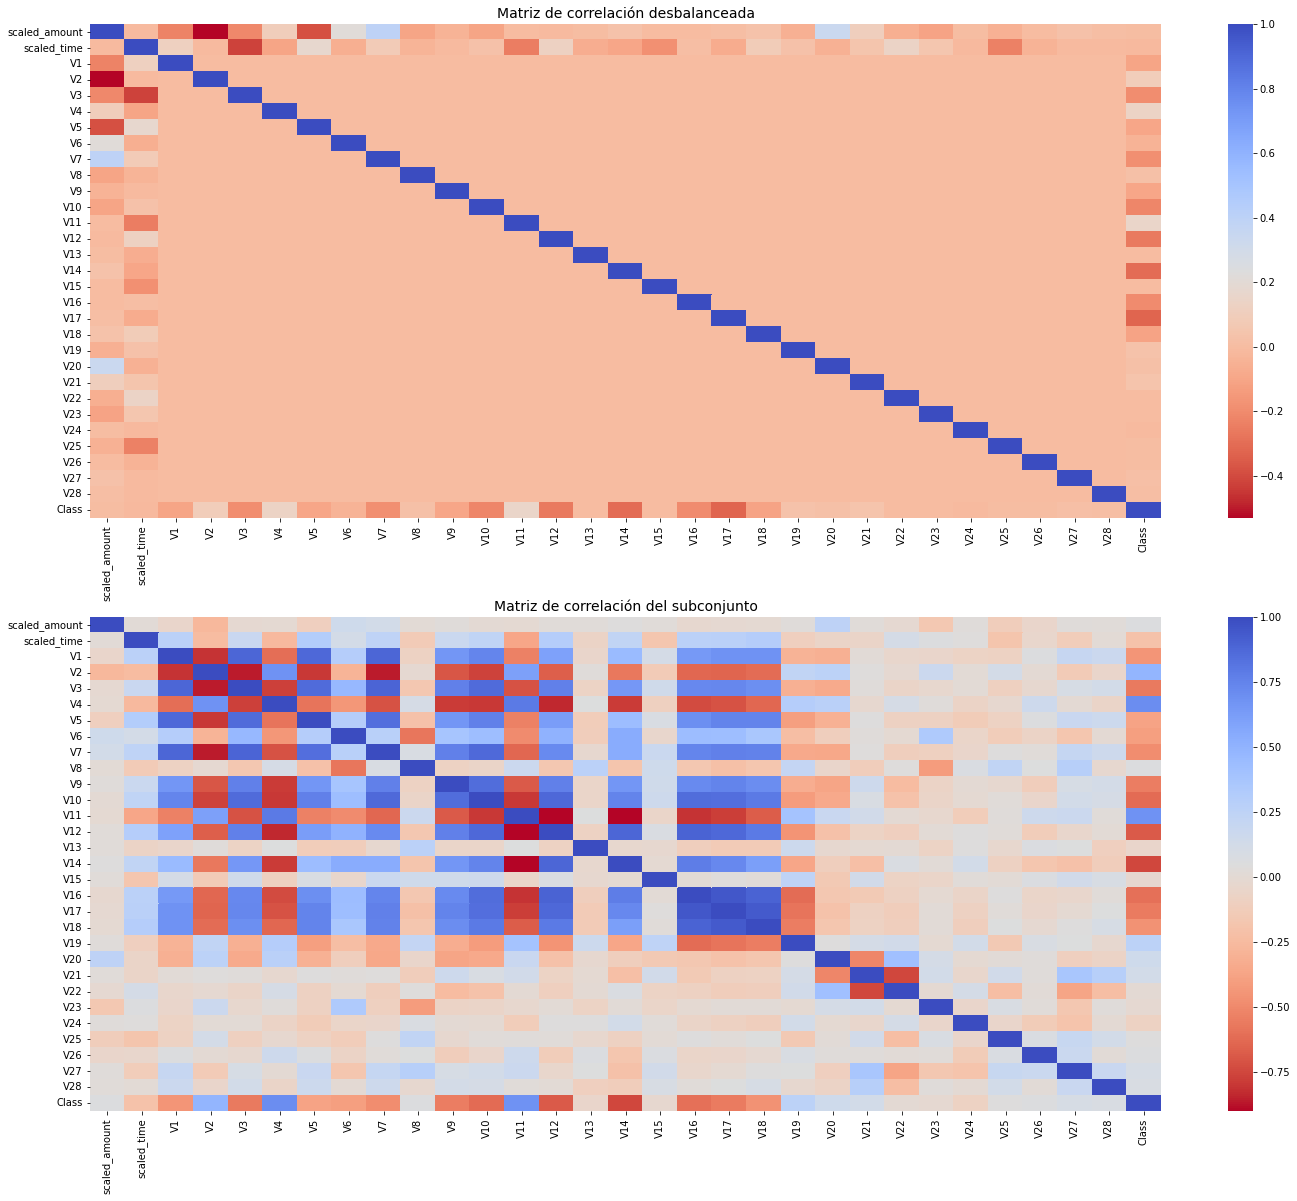

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('Matriz de correlación desbalanceada', fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Matriz de correlación del subconjunto', fontsize=14)
plt.show()

- **Correlaciones negativas:** V17, V14, V12 y V10 correlacionaron negativamente. Cuanto más bajos son estos valores, más probable es que el resultado final sea una transacción fraudulenta.

- **Correlaciones positivas:** V2, V4, V11 y V19 están correlacionados positivamente. Cuanto más altos son estos valores, más probable es que el resultado final sea una transacción fraudulenta.

## Correlaciones negativas

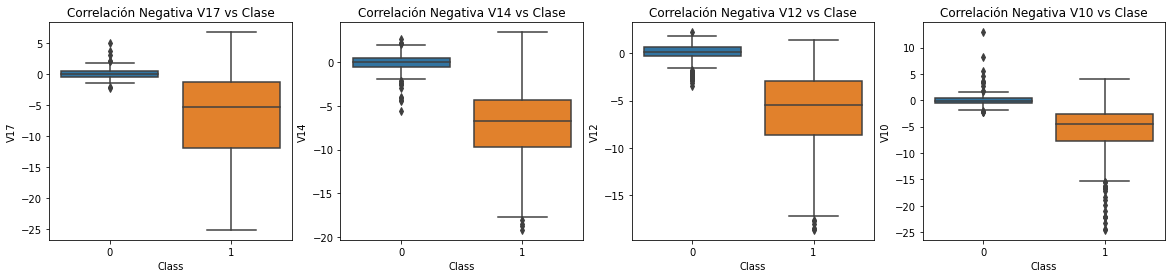

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x='Class', y='V17', data=new_df, ax=axes[0])
axes[0].set_title('Correlación Negativa V17 vs Clase')

sns.boxplot(x='Class', y='V14', data=new_df, ax=axes[1])
axes[1].set_title('Correlación Negativa V14 vs Clase')

sns.boxplot(x='Class', y='V12', data=new_df, ax=axes[2])
axes[2].set_title('Correlación Negativa V12 vs Clase')

sns.boxplot(x='Class', y='V10', data=new_df, ax=axes[3])
axes[3].set_title('Correlación Negativa V10 vs Clase')

plt.show()

## Correlaciones positivas

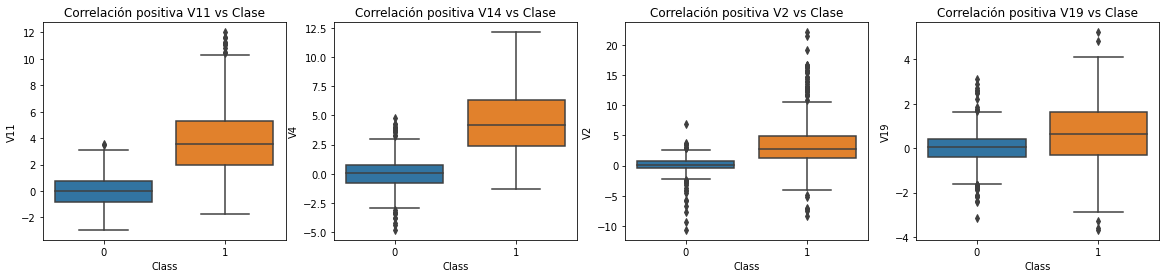

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x='Class', y='V11', data=new_df, ax=axes[0])
axes[0].set_title('Correlación positiva V11 vs Clase')

sns.boxplot(x='Class', y='V4', data=new_df, ax=axes[1])
axes[1].set_title('Correlación positiva V14 vs Clase')

sns.boxplot(x='Class', y='V2', data=new_df, ax=axes[2])
axes[2].set_title('Correlación positiva V2 vs Clase')

sns.boxplot(x='Class', y='V19', data=new_df, ax=axes[3])
axes[3].set_title('Correlación positiva V19 vs Clase')

plt.show()

## Eliminación de outliers

**Método de rango intercuartílico:**

- Rango Intercuartílico (IQR): Se calcula por la diferencia entre el percentil 75 y el percentil 25. El objetivo es crear un umbral más allá del percentil 75 y 25 que, en caso de que alguna instancia supere este umbral, sea eliminada.

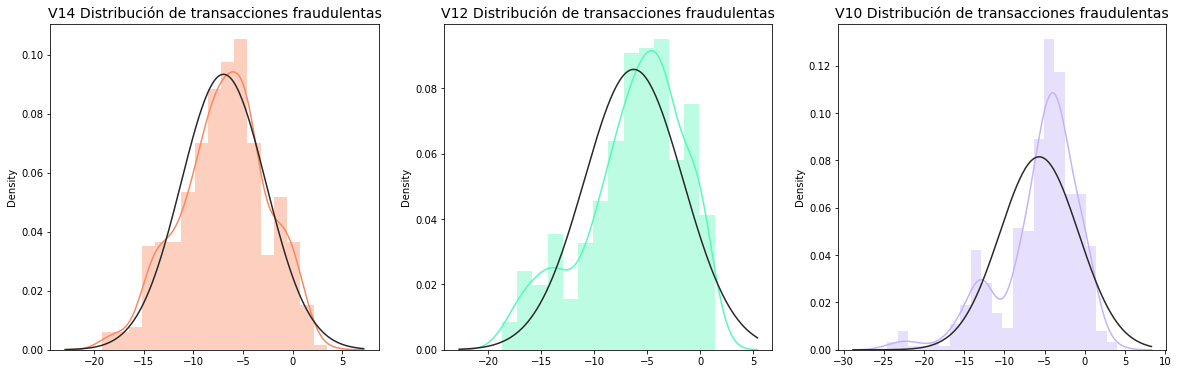

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribución de transacciones fraudulentas', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribución de transacciones fraudulentas', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribución de transacciones fraudulentas', fontsize=14)

plt.show()

V14 es la única función que tiene una distribución gaussiana en comparación con las funciones V12 y V10.

In [ ]:
# Eliminación de outliers V14

v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Corte: {}'.format(v14_cut_off))
print('V14 inferior: {}'.format(v14_lower))
print('V14 superior: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
print('V14 outliers para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Cantidad de instancias luego de la eliminación: {}'.format(len(new_df)))
print('-' * 50)

# Eliminación de outliers V12

v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('IQR: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Corte: {}'.format(v12_cut_off))
print('V12 inferior: {}'.format(v12_lower))
print('V12 superior: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('V12 outliers para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Cantidad de instancias luego de la eliminación: {}'.format(len(new_df)))
print('-' * 50)

# Eliminación de outliers V10

v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('IQR: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Corte: {}'.format(v10_cut_off))
print('V10 inferior: {}'.format(v10_lower))
print('V10 superior: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('V10 outliers para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Cantidad de instancias luego de la eliminación: {}'.format(len(new_df)))

Cuartil 25: -9.692722964972386 | Cuartil 75: -4.282820849486865
IQR: 5.409902115485521
Corte: 8.114853173228282
V14 inferior: -17.807576138200666
V14 superior: 3.8320323237414167
V14 outliers:[-18.0499976898594, -19.2143254902614, -18.8220867423816, -18.4937733551053]
V14 outliers para casos de fraude: 4
Cantidad de instancias luego de la eliminación: 980
--------------------------------------------------
Cuartil 25: -8.67303320439115 | Cuartil 75: -2.893030568676315
IQR: 5.780002635714835
Corte: 8.670003953572252
V12 inferior: -17.3430371579634
V12 superior: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.5536970096458, -18.4311310279993, -18.0475965708216]
V12 outliers para casos de fraude: 4
Cantidad de instancias luego de la eliminación: 976
--------------------------------------------------
Cuartil 25: -7.466658535821847 | Cuartil 75: -2.5118611381562523
IQR: 4.954797397665595
Corte: 7.432196096498393
V10 inferior: -14.89885463232024
V10 superior: 4.92033495834214
V10 outl

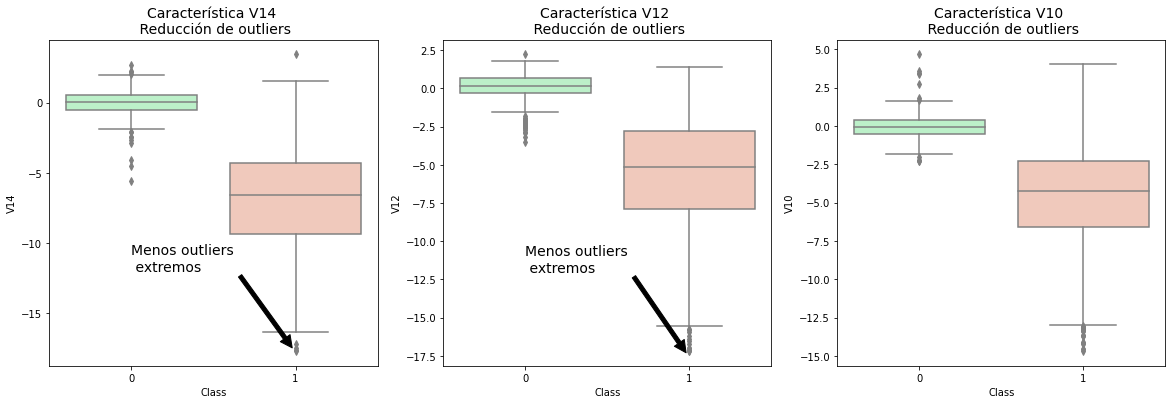

In [ ]:
# Boxplot de comparación

f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# V14
sns.boxplot(x='Class', y='V14', data=new_df,ax=ax1, palette=colors)
ax1.set_title('Característica V14 \n Reducción de outliers', fontsize=14)
ax1.annotate('Menos outliers \n extremos', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# V12
sns.boxplot(x='Class', y='V12', data=new_df, ax=ax2, palette=colors)
ax2.set_title('Característica V12 \n Reducción de outliers', fontsize=14)
ax2.annotate('Menos outliers \n extremos', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# V10
sns.boxplot(x='Class', y='V10', data=new_df, ax=ax3, palette=colors)
ax3.set_title('Característica V10 \n Reducción de outliers', fontsize=14)
ax3.annotate('Menos outliers \n extremos', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

El número de valores atípicos extremos se ha reducido a una cantidad considerable.

# Elección del algoritmo

Antes de evaluar los modelos, se separan los datos de training y testing.

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los valores en array para alimentar los algoritmos.

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Al estar ante un problema de clasificación, algunos modelos posibles para utilizar pueden ser los siguientes:

* Regresión logística
* K vecino más cercano
* Árboles de decisión

In [ ]:
# Modelos

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Métricas para validar el modelo

GridSearchCV se utiliza para determinar los parámetros que otorgan la mejor puntuación predictiva para los clasificadores.

In [ ]:
# Logistic Regression 
log_reg_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

# KNN
knears_params = {'n_neighbors': list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_

# DecisionTree Classifier
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(2,4,1)), 
              'min_samples_leaf': list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_

## Cross-Validation Score

In [ ]:
# Cross validation

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print('Classifiers: ', classifier.__class__.__name__, 'tiene un training score de', round(training_score.mean(), 2) * 100, '% de accuracy')

Classifiers:  LogisticRegression tiene un training score de 93.0 % de accuracy
Classifiers:  KNeighborsClassifier tiene un training score de 94.0 % de accuracy
Classifiers:  DecisionTreeClassifier tiene un training score de 90.0 % de accuracy


En principio, los modelos de **Logistic Regression Classifier** y **KNN** son más precisos que el de **DecisionTreeClassifier**.

## Matriz de confusión

- Cuadrado superior izquierdo: cantidad de transacciones sin fraude clasificadas correctamente por el modelo.
- Cuadrado superior derecho: cantidad de transacciones clasificadas incorrectamente como casos de fraude, pero la etiqueta real es sin fraude.
- Cuadrado inferior izquierdo: cantidad de transacciones clasificadas incorrectamente como casos sin fraude, pero la etiqueta real es fraude.
- Cuadrado inferior derecho: cantidad de transacciones fraudulentas clasificadas correctamente por nuestro modelo.


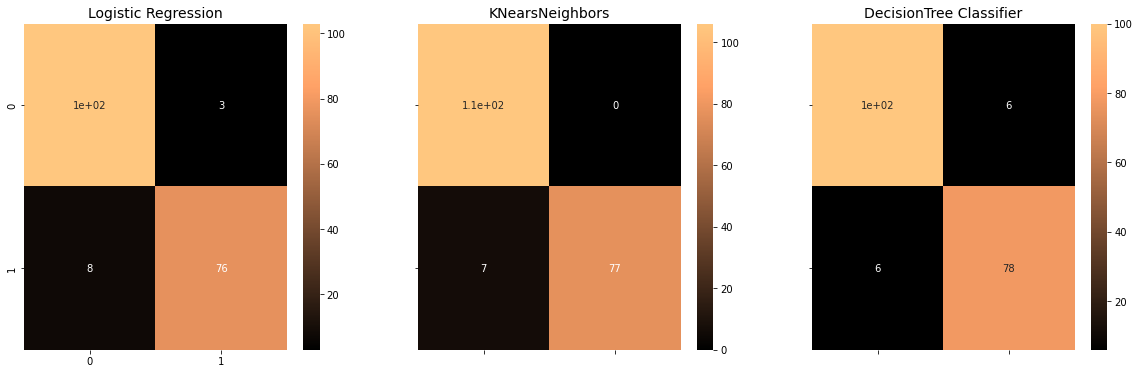

In [ ]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))

sns.heatmap(log_reg_cf, ax=ax1, annot=True, cmap=plt.cm.copper)
ax1.set_title('Logistic Regression', fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax3.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax2, annot=True, cmap=plt.cm.copper)
ax2.set_title('KNearsNeighbors', fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax3, annot=True, cmap=plt.cm.copper)
ax3.set_title('DecisionTree Classifier', fontsize=14)
ax3.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax3.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

Los modelos de regresión logística y KNN arrojan los mismos resultados.

## Métricas

In [ ]:
print('Logistic Regression: \n')
print(classification_report(y_test, y_pred_log_reg))

print('KNearest Neighbors: \n')
print(classification_report(y_test, y_pred_knear))

print('DesitionTree Classifier: \n')
print(classification_report(y_test, y_pred_tree))

Logistic Regression: 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       106
           1       0.96      0.90      0.93        84

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190

KNearest Neighbors: 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       106
           1       1.00      0.92      0.96        84

    accuracy                           0.96       190
   macro avg       0.97      0.96      0.96       190
weighted avg       0.97      0.96      0.96       190

DesitionTree Classifier: 

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       106
           1       0.93      0.93      0.93        84

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
we

Los modelos de regresión logística y KNN tienen los mismos scores.

# Conclusiones

El dataset original se encuentra muy desbalanceado, ya que solo el 0,2% de los datos representan casos de fraude. Para la correcta evaluación de los modelos predictivos, se realizó un ajuste, eliminando outliers en las características más importantes mediante el método IQR. Se analizaron 3 modelos de clasificación (LogisticRegression, KNN y DecisionTree) para los que se encontró que los modelos de regresión logística y k-vecino más cercano, fueron los mejores para predecir posibles casos de fraude.